<a href="https://colab.research.google.com/github/parul33/Deeplearning/blob/main/GAN7nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [17]:
# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Flatten the images and normalize
train_images = train_images.reshape(-1, 784).astype('float32')  # Flatten the images
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]


In [4]:
# Define buffer size and batch size
BUFFER_SIZE = 60000  # or any suitable number
BATCH_SIZE = 256     # or any suitable batch size

# Create a TensorFlow dataset, shuffle, and batch it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [5]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(1024, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(784, use_bias=False, activation='tanh')  # Output shape (None, 784)
    ])

    return model


In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(1024, input_shape=(784,)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(512),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(256),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(1)  # Output shape (None, 1)
    ])

    return model


In [9]:
# Define the noise dimension for the generator input
NOISE_DIM = 100  # Example: 100-dimensional noise vector

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real labels are 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake labels are 0
    total_loss = real_loss + fake_loss
    return total_loss


In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Try to fool the discriminator

# Define the optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [12]:
# Define the number of examples and the noise dimension
NUM_EXAMPLES_TO_GENERATE = 16  # You can adjust this value
NOISE_DIM = 100  # You can adjust this value

# Generate random noise as a seed for the generator
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])  # Generate random noise as input for the generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Forward pass for the generator
        generated_images = generator(noise, training=True)

        # Forward pass for the discriminator (real images)
        real_output = discriminator(images, training=True)

        # Forward pass for the discriminator (generated images)
        fake_output = discriminator(generated_images, training=True)

        # Calculate the losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to update the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [14]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)  # Generate images using the model
    predictions = predictions.numpy().reshape(-1, 28, 28)  # Reshape to 28x28 images

    # Create a figure to display images
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)  # Display 16 images in a 4x4 grid
        plt.imshow((predictions[i] * 127.5 + 127.5).astype(np.uint8), cmap='gray')  # Denormalize and display
        plt.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()  # Show the images


In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)  # Perform a training step for each batch

        # Produce images for the GIF as we go, every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}')
            generate_and_save_images(generator, epoch + 1, seed)


Epoch 10/50


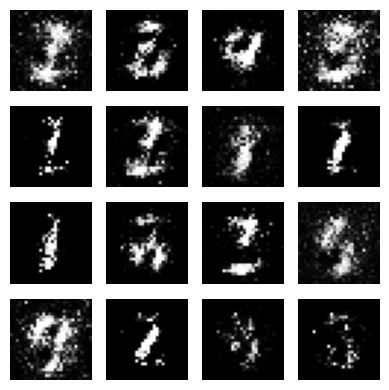

Epoch 20/50


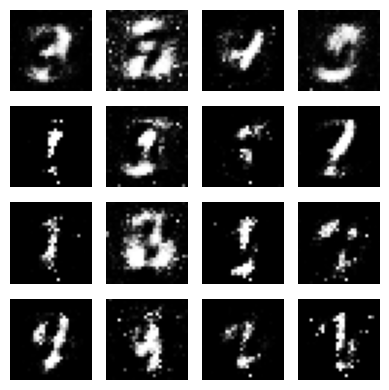

Epoch 30/50


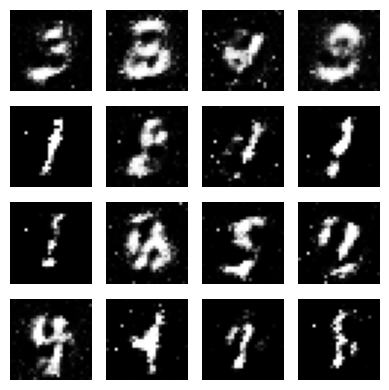

Epoch 40/50


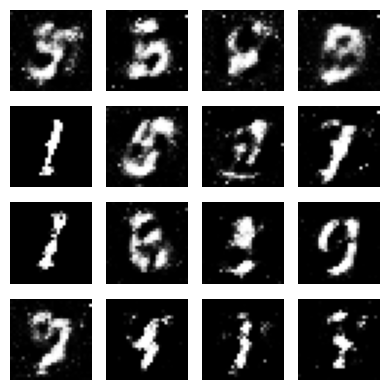

Epoch 50/50


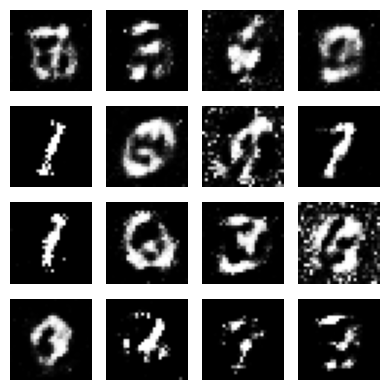

In [16]:
# Set the number of epochs
EPOCHS = 50  # Example: you can adjust this to any number of epochs you want to train for

# Make sure your train_dataset is defined correctly
# Example: train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Call the train function
train(train_dataset, EPOCHS)
